<p style="font-size:48px">Lab 7</p>

In [4]:
import numpy as np
import scipy.stats as sp
import pickle
import matplotlib.pyplot as plt

# 1)

In [5]:
# Importing pickle data
with (open("higgs.pkl", "rb")) as openfile:
    higgs = pickle.load(openfile)
with (open("qcd.pkl", "rb")) as openfile:
    qcd = pickle.load(openfile)

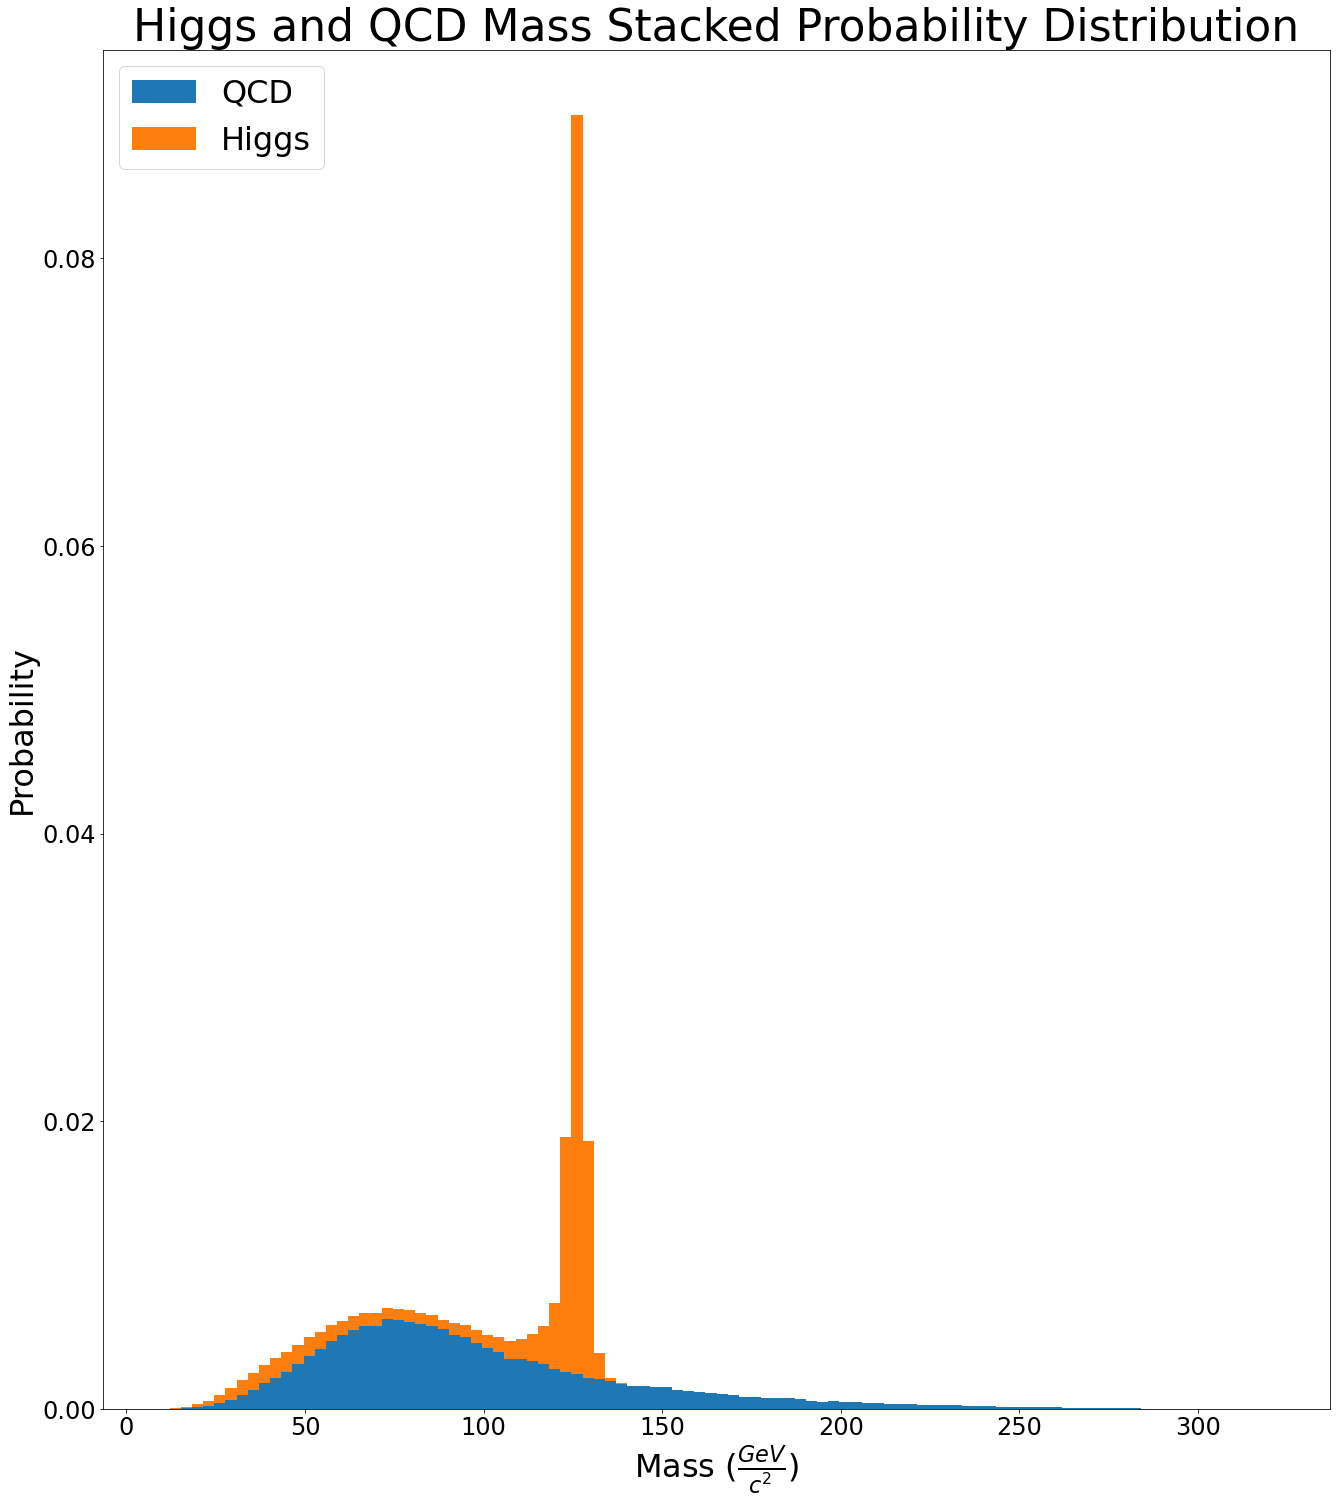

In [42]:
plt.rcParams["figure.figsize"] = (22,25)

plt.hist([qcd['mass'],higgs['mass']], histtype='bar',bins = 100, density = True, stacked=True, label = ['QCD', 'Higgs'])
plt.legend(loc="upper left", fontsize = 32)
plt.xlabel('Mass ($\\frac{GeV}{c^2}$)', fontsize = 32)
plt.ylabel('Probability', fontsize = 32)
plt.title('Higgs and QCD Mass Stacked Probability Distribution', fontsize = 44)
plt.tick_params(labelsize = 24)
plt.show()